In [6]:
import numpy as np

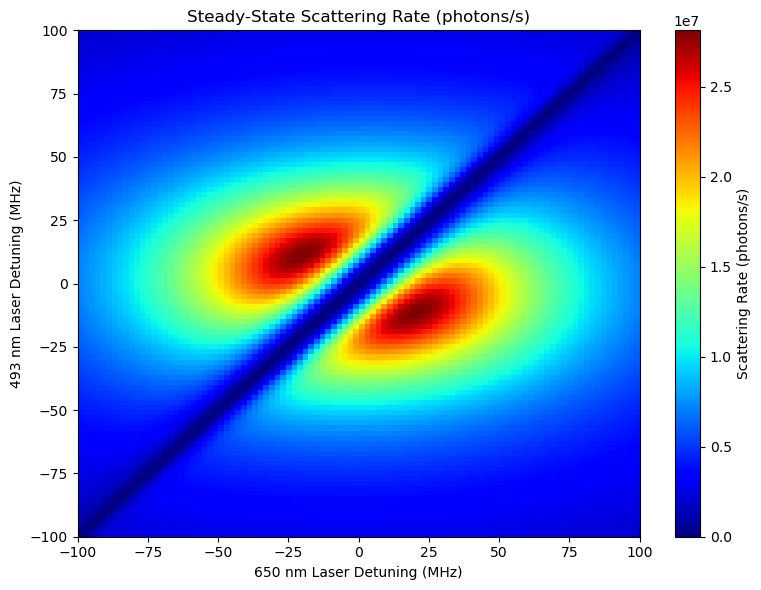

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la

# ------------------------------
# Parameters
# ------------------------------
pi = np.pi

# Total decay rate from the 6P1/2 state (in rad/s)
Gamma = 2 * pi * 20e6  # e.g. 20 MHz linewidth

# Branching ratios (from Clebsch–Gordan analysis + frequency factors)
b_S = 0.75455  # fraction decaying to S (producing 493 nm fluorescence)
b_D = 0.24544  # fraction decaying to D (metastable)

# Rabi frequencies (in rad/s)
Omega_493 = 2 * pi * 30e6  # for the 493 nm transition
Omega_650 = 2 * pi * 30e6   # for the 650 nm repump transition

# ------------------------------
# Function to compute the steady-state scattering rate for given detunings.
#
# The Hamiltonian in the {|S>,|P>,|D>} basis is:
#
#   H[0,0] = 0
#   H[0,1] = H[1,0] = Omega_493/2
#   H[1,1] = -Delta493
#   H[1,2] = H[2,1] = Omega_650/2
#   H[2,2] = -(Delta493 - Delta650)
#
# The collapse operators are:
#   C_S = sqrt(Gamma*b_S) |S><P|
#   C_D = sqrt(Gamma*b_D) |D><P|
# ------------------------------
def steady_state_scattering_rate(Delta493, Delta650):
    # Construct the 3x3 Hamiltonian H:
    H = np.zeros((3, 3), dtype=complex)
    H[0, 1] = Omega_493/2.0
    H[1, 0] = Omega_493/2.0
    H[1, 1] = -Delta493
    H[1, 2] = Omega_650/2.0
    H[2, 1] = Omega_650/2.0
    H[2, 2] = -(Delta493 - Delta650)
    
    # Define collapse operators (3x3 matrices)
    C_S = np.zeros((3, 3), dtype=complex)
    C_S[0, 1] = np.sqrt(Gamma * b_S)
    
    C_D = np.zeros((3, 3), dtype=complex)
    C_D[2, 1] = np.sqrt(Gamma * b_D)
    
    C_ops = [C_S, C_D]
    
    # Identity in 3 dimensions:
    I3 = np.eye(3, dtype=complex)
    
    # Build the Liouvillian superoperator L (9x9 matrix)
    # The coherent part: -i (Hρ - ρH) becomes: -i*(I⊗H - H^T⊗I)
    L = -1j * (np.kron(I3, H) - np.kron(H.T, I3))
    
    # Add each collapse operator contribution:
    for C in C_ops:
        C_dag = C.conj().T
        # The "jump" term: C ρ C^\dagger  ->  kron(C_dag.T, C)
        L += np.kron(C_dag.T, C)
        # The damping terms: -0.5*(I⊗(C^\dagger C) + (C^\dagger C)^T⊗I)
        CC = C_dag @ C
        L -= 0.5 * (np.kron(I3, CC) + np.kron(CC.T, I3))
    
    # L acts on the vectorized density matrix (a 9-element vector).
    # We now solve for the steady state, L * vec(rho) = 0.
    evals, evecs = la.eig(L)
    # Find the eigenvector corresponding to the eigenvalue closest to zero.
    idx = np.argmin(np.abs(evals))
    rho_ss_vec = evecs[:, idx]
    # Reshape the 9-vector into a 3x3 matrix:
    rho_ss = rho_ss_vec.reshape((3, 3))
    # Normalize so that Tr(rho) = 1:
    rho_ss = rho_ss / np.trace(rho_ss)
    
    # Extract the population in |P> (state index 1)
    rho_P = np.real(rho_ss[1, 1])
    
    # The scattering rate (rate of 493 nm photons) is given by decays from |P> to |S>:
    R_sc = Gamma * b_S * rho_P
    return R_sc

N = 100  # grid size

Delta493_list = np.linspace(-2*pi*100e6, 2*pi*100e6, N)
Delta650_list = np.linspace(-2*pi*100e6, 2*pi*100e6, N)

# Prepare an array to hold the scattering rates.
R_sc_grid = np.zeros((N, N))

for i, d493 in enumerate(Delta493_list):
    for j, d650 in enumerate(Delta650_list):
        R_sc_grid[i, j] = steady_state_scattering_rate(d493, d650)

plt.figure(figsize=(8, 6))

Delta493_MHz = Delta493_list / (2*pi*1e6)
Delta650_MHz = Delta650_list / (2*pi*1e6)

extent = [Delta650_MHz[0], Delta650_MHz[-1], Delta493_MHz[0], Delta493_MHz[-1]]
im = plt.imshow(R_sc_grid, extent=extent, origin='lower', aspect='auto', cmap='jet')
plt.xlabel('650 nm Laser Detuning (MHz)')
plt.ylabel('493 nm Laser Detuning (MHz)')
plt.title('Steady-State Scattering Rate (photons/s)')
plt.colorbar(im, label='Scattering Rate (photons/s)')
plt.tight_layout()
plt.show()


In [12]:
%matplotlib widget

RuntimeError: 'widget is not a recognised GUI loop or backend name

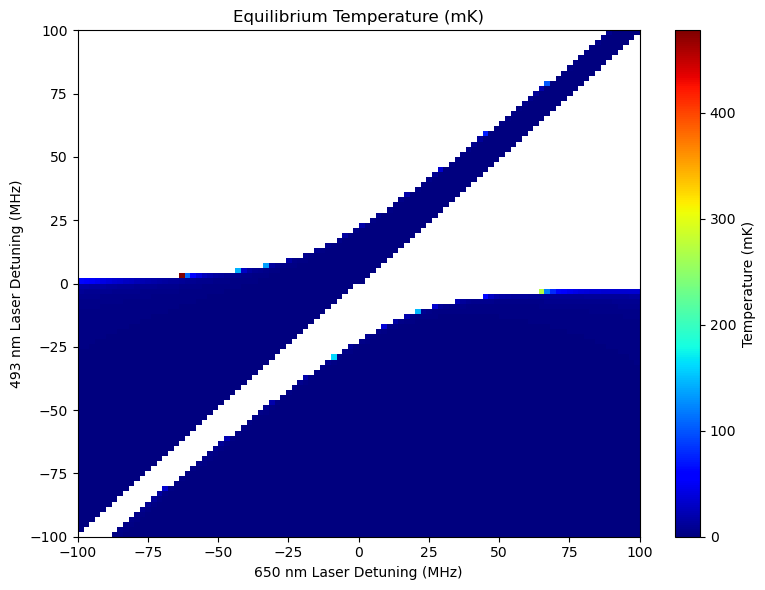

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la

# ------------------------------
# Fundamental constants (SI units)
# ------------------------------
hbar = 1.0545718e-34       # reduced Planck constant, J*s
k_B = 1.38064852e-23       # Boltzmann constant, J/K
c = 299792458             # speed of light, m/s

# ------------------------------
# Experimental parameters
# ------------------------------
pi = np.pi

# Decay rate from the 6P1/2 state (in rad/s)
Gamma = 2 * pi * 20e6  # 20 MHz linewidth

# Branching ratios (from Clebsch–Gordan analysis + frequency factors)
b_S = 0.75455  # fraction decaying to S (producing 493 nm fluorescence)
b_D = 0.24544  # fraction decaying to D (metastable)

# Rabi frequencies (in rad/s)
Omega_493 = 2 * pi * 30e6  # for the 493 nm transition
Omega_650 = 2 * pi * 30e6  # for the 650 nm repump transition

# Wavelength and wavevector for 493 nm light
lambda_493 = 493e-9        # 493 nm in meters
k_493 = 2 * pi / lambda_493

# ------------------------------
# Modified function to compute the steady-state scattering rate,
# now with Doppler shift. The effective detuning is:
#   Delta_eff = Delta493 - k_493 * v
# ------------------------------
def steady_state_scattering_rate(Delta493, Delta650, v=0.0):
    # Effective 493 detuning including Doppler shift:
    Delta_eff = Delta493 - k_493 * v
    
    # Construct the 3x3 Hamiltonian H in the {|S>, |P>, |D>} basis:
    H = np.zeros((3, 3), dtype=complex)
    H[0, 1] = Omega_493 / 2.0
    H[1, 0] = Omega_493 / 2.0
    H[1, 1] = -Delta_eff
    H[1, 2] = Omega_650 / 2.0
    H[2, 1] = Omega_650 / 2.0
    H[2, 2] = -(Delta_eff - Delta650)
    
    # Define collapse operators (3x3 matrices)
    C_S = np.zeros((3, 3), dtype=complex)
    C_S[0, 1] = np.sqrt(Gamma * b_S)
    
    C_D = np.zeros((3, 3), dtype=complex)
    C_D[2, 1] = np.sqrt(Gamma * b_D)
    
    C_ops = [C_S, C_D]
    
    # Identity matrix in 3 dimensions:
    I3 = np.eye(3, dtype=complex)
    
    # Build the Liouvillian superoperator L (9x9 matrix)
    # The coherent part: -i*(H*rho - rho*H) becomes:
    #   -i*(I ⊗ H - H^T ⊗ I)
    L = -1j * (np.kron(I3, H) - np.kron(H.T, I3))
    
    # Add collapse operator contributions:
    for C in C_ops:
        C_dag = C.conj().T
        # Jump term: C ρ C^† becomes kron(C_dag.T, C)
        L += np.kron(C_dag.T, C)
        # Damping terms: -0.5*(I ⊗ (C^† C) + (C^† C)^T ⊗ I)
        CC = C_dag @ C
        L -= 0.5 * (np.kron(I3, CC) + np.kron(CC.T, I3))
    
    # Solve for the steady state: L * vec(rho_ss) = 0
    evals, evecs = la.eig(L)
    # Choose the eigenvector with eigenvalue closest to zero
    idx = np.argmin(np.abs(evals))
    rho_ss_vec = evecs[:, idx]
    # Reshape the 9-element vector to a 3x3 density matrix:
    rho_ss = rho_ss_vec.reshape((3, 3))
    # Normalize so that Tr(rho) = 1
    rho_ss = rho_ss / np.trace(rho_ss)
    
    # Extract population in |P> (state index 1)
    rho_P = np.real(rho_ss[1, 1])
    
    # Scattering rate: rate of decays from |P> to |S>
    R_sc = Gamma * b_S * rho_P
    return R_sc

# ------------------------------
# Define a function to compute the scattering force
# F(v) = hbar * k_493 * R_sc(v)
# ------------------------------
def scattering_force(Delta493, Delta650, v=0.0):
    R_sc = steady_state_scattering_rate(Delta493, Delta650, v)
    return hbar * k_493 * R_sc

# ------------------------------
# Set up grid of detunings (in rad/s)
# ------------------------------
N = 100  # grid size
Delta493_list = np.linspace(-2*pi*100e6, 2*pi*100e6, N)
Delta650_list = np.linspace(-2*pi*100e6, 2*pi*100e6, N)

# Small velocity increment for derivative (in m/s)
dv = 0.001  # adjust as needed for numerical differentiation

# Prepare an array to hold equilibrium temperatures (in Kelvin)
T_grid = np.zeros((N, N))

# Loop over detuning grid:
for i, d493 in enumerate(Delta493_list):
    for j, d650 in enumerate(Delta650_list):
        # Compute scattering rate and force at v = 0
        F0 = scattering_force(d493, d650, v=0.0)
        # Compute forces at small positive and negative velocities:
        F_plus = scattering_force(d493, d650, v=dv)
        F_minus = scattering_force(d493, d650, v=-dv)
        # Numerical derivative: friction coefficient alpha = -dF/dv at v=0
        alpha = -(F_plus - F_minus) / (2 * dv)
        
        # Compute diffusion coefficient D = 0.5 * (hbar*k_493)^2 * R_sc(v=0)
        R_sc0 = steady_state_scattering_rate(d493, d650, v=0.0)
        D = 0.5 * (hbar * k_493)**2 * R_sc0
        
        # Check that alpha is positive (cooling). If not, set T to a high value.
        if alpha > 0:
            T = D / (alpha * k_B)
        else:
            T = np.nan  # or a large number to indicate no cooling region
        T_grid[i, j] = T

# ------------------------------
# Plotting: Temperature vs. 493 and 650 detunings.
# We'll convert detunings from rad/s to MHz, and T to mK.
# ------------------------------
plt.figure(figsize=(8, 6))

Delta493_MHz = Delta493_list / (2 * pi * 1e6)
Delta650_MHz = Delta650_list / (2 * pi * 1e6)
T_mK = T_grid * 1e3  # convert Kelvin to mK

# Set the extent for imshow: [x_min, x_max, y_min, y_max]
extent = [Delta650_MHz[0], Delta650_MHz[-1], Delta493_MHz[0], Delta493_MHz[-1]]
im = plt.imshow(T_mK, extent=extent, origin='lower', aspect='auto', cmap='jet')
plt.xlabel('650 nm Laser Detuning (MHz)')
plt.ylabel('493 nm Laser Detuning (MHz)')
plt.title('Equilibrium Temperature (mK)')
plt.colorbar(im, label='Temperature (mK)')
plt.tight_layout()
plt.show()


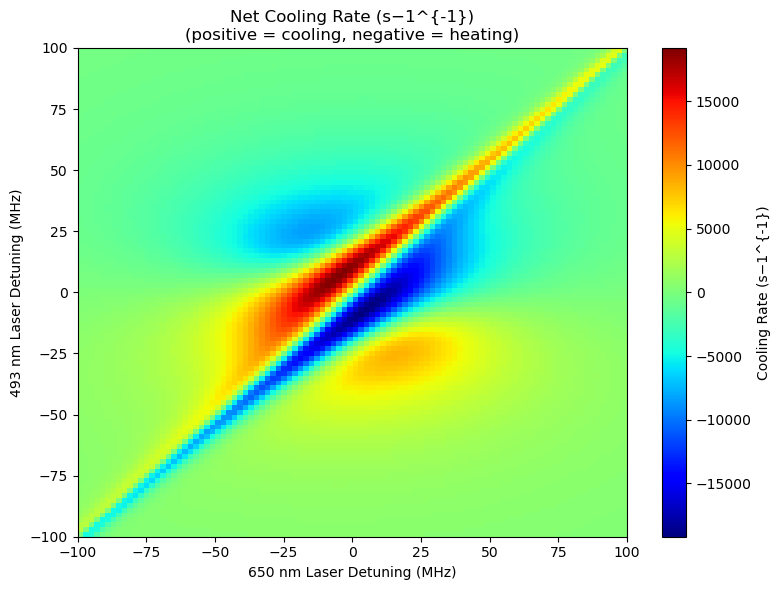

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la

# ------------------------------
# Fundamental constants (SI units)
# ------------------------------
hbar = 1.0545718e-34       # reduced Planck constant, J*s
k_B = 1.38064852e-23       # Boltzmann constant, J/K
c = 299792458             # speed of light, m/s

pi = np.pi

# ------------------------------
# Experimental parameters
# ------------------------------
# Decay rate from the 6P1/2 state (in rad/s)
Gamma = 2 * pi * 20e6  # 20 MHz linewidth

# Branching ratios (from Clebsch–Gordan analysis + frequency factors)
b_S = 0.75455  # fraction decaying to S (producing 493 nm fluorescence)
b_D = 0.24544  # fraction decaying to D (metastable)

# Rabi frequencies (in rad/s)
Omega_493 = 2 * pi * 30e6  # for the 493 nm transition
Omega_650 = 2 * pi * 30e6  # for the 650 nm repump transition

# Wavelength and wavevector for 493 nm light
lambda_493 = 493e-9        # 493 nm in meters
k_493 = 2 * pi / lambda_493

# ------------------------------
# Ion mass (Ba+ 138); 1 amu = 1.660539e-27 kg
# ------------------------------
m_Ba = 137.327 * 1.660539e-27  # in kg

# ------------------------------
# Function to compute the steady-state scattering rate with Doppler shift.
# The effective detuning for the 493 nm laser is:
#   Delta_eff = Delta493 - k_493 * v
# ------------------------------
def steady_state_scattering_rate(Delta493, Delta650, v=0.0):
    # Effective 493 detuning including Doppler shift:
    Delta_eff = Delta493 - k_493 * v
    
    # Construct the 3x3 Hamiltonian H in the {|S>, |P>, |D>} basis:
    H = np.zeros((3, 3), dtype=complex)
    H[0, 1] = Omega_493 / 2.0
    H[1, 0] = Omega_493 / 2.0
    H[1, 1] = -Delta_eff
    H[1, 2] = Omega_650 / 2.0
    H[2, 1] = Omega_650 / 2.0
    H[2, 2] = -(Delta_eff - Delta650)
    
    # Define collapse operators (3x3 matrices)
    C_S = np.zeros((3, 3), dtype=complex)
    C_S[0, 1] = np.sqrt(Gamma * b_S)
    
    C_D = np.zeros((3, 3), dtype=complex)
    C_D[2, 1] = np.sqrt(Gamma * b_D)
    
    C_ops = [C_S, C_D]
    
    # Identity matrix in 3 dimensions:
    I3 = np.eye(3, dtype=complex)
    
    # Build the Liouvillian superoperator L (9x9 matrix)
    # Coherent part: -i*(Hρ - ρH) -> -i*(I⊗H - H^T⊗I)
    L = -1j * (np.kron(I3, H) - np.kron(H.T, I3))
    
    # Add collapse operator contributions:
    for C in C_ops:
        C_dag = C.conj().T
        # Jump term: C ρ C† -> kron(C_dag.T, C)
        L += np.kron(C_dag.T, C)
        # Damping terms: -0.5*(I⊗(C†C) + (C†C)^T⊗I)
        CC = C_dag @ C
        L -= 0.5 * (np.kron(I3, CC) + np.kron(CC.T, I3))
    
    # Solve for the steady state: L * vec(rho_ss) = 0
    evals, evecs = la.eig(L)
    # Select the eigenvector with eigenvalue closest to zero
    idx = np.argmin(np.abs(evals))
    rho_ss_vec = evecs[:, idx]
    # Reshape the 9-element vector to a 3x3 density matrix:
    rho_ss = rho_ss_vec.reshape((3, 3))
    # Normalize so that Tr(rho) = 1
    rho_ss = rho_ss / np.trace(rho_ss)
    
    # Extract the population in |P> (state index 1)
    rho_P = np.real(rho_ss[1, 1])
    
    # Scattering rate: decays from |P> to |S>
    R_sc = Gamma * b_S * rho_P
    return R_sc

# ------------------------------
# Function to compute the scattering force:
# F(v) = hbar * k_493 * R_sc(v)
# ------------------------------
def scattering_force(Delta493, Delta650, v=0.0):
    R_sc = steady_state_scattering_rate(Delta493, Delta650, v)
    return hbar * k_493 * R_sc

# ------------------------------
# Grid of detunings (in rad/s)
# ------------------------------
N = 100  # grid size
Delta493_list = np.linspace(-2*pi*100e6, 2*pi*100e6, N)
Delta650_list = np.linspace(-2*pi*100e6, 2*pi*100e6, N)

# Small velocity increment for numerical derivative (in m/s)
dv = 0.001  

# Prepare an array to hold the friction coefficient alpha (N/(m/s))
alpha_grid = np.zeros((N, N))

# Loop over detuning grid and compute friction coefficient:
for i, d493 in enumerate(Delta493_list):
    for j, d650 in enumerate(Delta650_list):
        F_plus = scattering_force(d493, d650, v=dv)
        F_minus = scattering_force(d493, d650, v=-dv)
        # Friction coefficient: alpha = -dF/dv at v=0
        alpha = -(F_plus - F_minus) / (2 * dv)
        alpha_grid[i, j] = alpha

# Compute net cooling (or heating) rate: r = alpha/m_Ba (in s^-1)
# Here r > 0 corresponds to cooling, r < 0 to heating.
r_grid = alpha_grid / m_Ba

# ------------------------------
# Plotting: Net Cooling Rate vs. 493 and 650 detunings.
# Convert detunings from rad/s to MHz.
# ------------------------------
plt.figure(figsize=(8, 6))
Delta493_MHz = Delta493_list / (2 * pi * 1e6)
Delta650_MHz = Delta650_list / (2 * pi * 1e6)
extent = [Delta650_MHz[0], Delta650_MHz[-1], Delta493_MHz[0], Delta493_MHz[-1]]
im = plt.imshow(r_grid, extent=extent, origin='lower', aspect='auto', cmap='jet')
plt.xlabel('650 nm Laser Detuning (MHz)')
plt.ylabel('493 nm Laser Detuning (MHz)')
plt.title('Net Cooling Rate (s−1^{-1})\n(positive = cooling, negative = heating)')
plt.colorbar(im, label='Cooling Rate (s−1^{-1})')
plt.tight_layout()
plt.show()
